# Building an Inception CNN

This is a copied and modified version of this great tutorial, [Inception models: explained and implimented](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/).

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Data, preprocessing and miscellaneous functions

Following the Inception models tutorial, we'll use the csv-ified version of the MNIST data set.

In [2]:
train_set = np.loadtxt('mnist_train.csv', delimiter=',')
test_set = np.loadtxt('mnist_test.csv', delimiter=',')

For number image, the data is a row of:

> number label (actual number value of the image), unravelled image data 

Let's print out the data shape and first few rows to see:

In [3]:
print('Data shape:')
print(train_set.shape)

print('\nData:')
train_set[0:5]

Data shape:
(60000, 785)

Data:


array([[ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  0.,  0., ...,  0.,  0.,  0.]])

In [4]:
# extract the labels
train_label_values = train_set[:, 0]
test_label_values = test_set[:, 0]

# one hot encode the labels
#   in one hot encoding, we take our class labels and turn them into a vector of 1s and 0s, where each 
#   class is one element position of the vector, which is set to 1/True if the label is of that class
train_labels = (np.arange(10) == train_label_values[:,None]).astype(np.float32)
test_labels = (np.arange(10) == test_label_values[:,None]).astype(np.float32)

print('One hot encoded label example:')
print(test_label_values[0], test_labels[0])
# the vector position 7 is assigned to class 7 in this case
# so the vector is 1 there and zero elsewhere for this data element 

One hot encoded label example:
7.0 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [5]:
# now extract the image data, by leaving out the first label column 
#   also convert to 
trainX = train_set[:, 1:]
testX = test_set[:, 1:]

print('data shape:')
print(trainX.shape)

data shape:
(60000, 784)


In [6]:
# now reshape each row into the image shape
trainX = trainX.reshape(len(trainX),28,28,1)
testX = testX.reshape(len(testX),28,28,1)

print('data shape:')
print(trainX.shape)
# Note that we add the extra 1 dimension because these networks case input images with multiple colour panes
# So the final dimension could be 3 for RGB, for example.
# In this example our data is just black and white.

data shape:
(60000, 28, 28, 1)


In [7]:
# take the final 500 images in the list to be a validation set, and use the rest for training.
n_validation = 500
n_total = len(trainX)
n_train = n_total - n_validation

valX = trainX[n_train:]
val_lb = train_labels[n_train:]

trainX = trainX[0:n_train]
train_lb = train_labels[0:n_train]

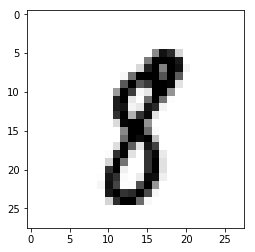

In [8]:
# check an image!
example_image = trainX[300, :, :, 0]
plt.imshow(example_image, cmap="Greys")

In [9]:
# following the Inception models tutorial's cleverness:
#   need to batch the test data because running low on memory
class test_batchs:
    def __init__(self,data):
        self.data = data
        self.batch_index = 0
    def nextBatch(self,batch_size):
        if (batch_size+self.batch_index) > self.data.shape[0]:
            print("batch sized is messed up")
        batch = self.data[self.batch_index:(self.batch_index+batch_size),:,:,:]
        self.batch_index= self.batch_index+batch_size
        return batch

# set the test batchsize
test_batch_size = 100

In [10]:
# following the Inception models tutorial:
#   returns accuracy of model
def accuracy(target, predictions):
    return(100.0*np.sum(np.argmax(target,1) == np.argmax(predictions,1))/target.shape[0])

In [11]:
# save the ourput model in our current working directory
file_path = os.getcwd() + '/model.ckpt'

## Create Google Inception model

In [12]:
batch_size = 50
map1 = 32
map2 = 64
num_fc1 = 700 #1028
num_fc2 = 10
reduce1x1 = 16
dropout = 0.5

graph = tf.Graph()
with graph.as_default():
    # ---------------------------------------------------------------------------------
    # create tensorflow place holder tensors for the input and output data our model will use
    
    # training data and labels
    X = tf.placeholder(tf.float32, shape=(batch_size,28,28,1))
    y_ = tf.placeholder(tf.float32, shape=(batch_size,10))
    
    # validation data
    tf_valX = tf.placeholder(tf.float32, shape=(len(valX),28,28,1))
    
    # test data (for a batch at a time)
    tf_testX=tf.placeholder(tf.float32, shape=(test_batch_size,28,28,1))
    
    # single element test data
    tf_singleX=tf.placeholder(tf.float32, shape=(1,28,28,1))
    
    def createWeight(size,Name):
        return tf.Variable(tf.truncated_normal(size, stddev=0.1),
                          name=Name)
    
    def createBias(size,Name):
        return tf.Variable(tf.constant(0.1,shape=size),
                          name=Name)
    
    def conv2d_s1(x,W):
        return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')
    
    def max_pool_3x3_s1(x):
        return tf.nn.max_pool(x,ksize=[1,3,3,1],
                             strides=[1,1,1,1],padding='SAME')
    
    # ---------------------------------------------------------------------------------
    # Inception Module1
    #
    # follows input
    W_conv1_1x1_1 = createWeight([1,1,1,map1],'W_conv1_1x1_1')
    b_conv1_1x1_1 = createWeight([map1],'b_conv1_1x1_1')
    
    # follows input
    W_conv1_1x1_2 = createWeight([1,1,1,reduce1x1],'W_conv1_1x1_2')
    b_conv1_1x1_2 = createWeight([reduce1x1],'b_conv1_1x1_2')
    
    # follows input
    W_conv1_1x1_3 = createWeight([1,1,1,reduce1x1],'W_conv1_1x1_3')
    b_conv1_1x1_3 = createWeight([reduce1x1],'b_conv1_1x1_3')
    
    # follows 1x1_2
    W_conv1_3x3 = createWeight([3,3,reduce1x1,map1],'W_conv1_3x3')
    b_conv1_3x3 = createWeight([map1],'b_conv1_3x3')
    
    # follows 1x1_3
    W_conv1_5x5 = createWeight([5,5,reduce1x1,map1],'W_conv1_5x5')
    b_conv1_5x5 = createBias([map1],'b_conv1_5x5')
    
    # follows max pooling
    W_conv1_1x1_4= createWeight([1,1,1,map1],'W_conv1_1x1_4')
    b_conv1_1x1_4= createWeight([map1],'b_conv1_1x1_4')
    
    
    # ---------------------------------------------------------------------------------
    # Inception Module2
    #
    # follows inception1
    W_conv2_1x1_1 = createWeight([1,1,4*map1,map2],'W_conv2_1x1_1')
    b_conv2_1x1_1 = createWeight([map2],'b_conv2_1x1_1')
    
    # follows inception1
    W_conv2_1x1_2 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_2')
    b_conv2_1x1_2 = createWeight([reduce1x1],'b_conv2_1x1_2')
    
    # follows inception1
    W_conv2_1x1_3 = createWeight([1,1,4*map1,reduce1x1],'W_conv2_1x1_3')
    b_conv2_1x1_3 = createWeight([reduce1x1],'b_conv2_1x1_3')
    
    # follows 1x1_2
    W_conv2_3x3 = createWeight([3,3,reduce1x1,map2],'W_conv2_3x3')
    b_conv2_3x3 = createWeight([map2],'b_conv2_3x3')
    
    # follows 1x1_3
    W_conv2_5x5 = createWeight([5,5,reduce1x1,map2],'W_conv2_5x5')
    b_conv2_5x5 = createBias([map2],'b_conv2_5x5')
    
    # follows max pooling
    W_conv2_1x1_4= createWeight([1,1,4*map1,map2],'W_conv2_1x1_4')
    b_conv2_1x1_4= createWeight([map2],'b_conv2_1x1_4')
    
    
    # ---------------------------------------------------------------------------------
    # Fully connected layers
    # since padding is same, the feature map with there will be 4 28*28*map2
    W_fc1 = createWeight([28*28*(4*map2),num_fc1],'W_fc1')
    b_fc1 = createBias([num_fc1],'b_fc1')
    
    W_fc2 = createWeight([num_fc1,num_fc2],'W_fc2')
    b_fc2 = createBias([num_fc2],'b_fc2')
    
    # ---------------------------------------------------------------------------------
    # Stitch model together

    def model(x,train=True):
        # Inception Module 1
        conv1_1x1_1 = conv2d_s1(x,W_conv1_1x1_1)+b_conv1_1x1_1
        conv1_1x1_2 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_2)+b_conv1_1x1_2)
        conv1_1x1_3 = tf.nn.relu(conv2d_s1(x,W_conv1_1x1_3)+b_conv1_1x1_3)
        conv1_3x3 = conv2d_s1(conv1_1x1_2,W_conv1_3x3)+b_conv1_3x3
        conv1_5x5 = conv2d_s1(conv1_1x1_3,W_conv1_5x5)+b_conv1_5x5
        maxpool1 = max_pool_3x3_s1(x)
        conv1_1x1_4 = conv2d_s1(maxpool1,W_conv1_1x1_4)+b_conv1_1x1_4
        
        # concatenate all the feature maps and hit them with a relu
        #   (this line edited from original tutorial -- presumably a version change issue)
        inception1 = tf.nn.relu(tf.concat([conv1_1x1_1,conv1_3x3,conv1_5x5,conv1_1x1_4], 3))

        
        # Inception Module 2
        conv2_1x1_1 = conv2d_s1(inception1,W_conv2_1x1_1)+b_conv2_1x1_1
        conv2_1x1_2 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_2)+b_conv2_1x1_2)
        conv2_1x1_3 = tf.nn.relu(conv2d_s1(inception1,W_conv2_1x1_3)+b_conv2_1x1_3)
        conv2_3x3 = conv2d_s1(conv2_1x1_2,W_conv2_3x3)+b_conv2_3x3
        conv2_5x5 = conv2d_s1(conv2_1x1_3,W_conv2_5x5)+b_conv2_5x5
        maxpool2 = max_pool_3x3_s1(inception1)
        conv2_1x1_4 = conv2d_s1(maxpool2,W_conv2_1x1_4)+b_conv2_1x1_4
        
        # concatenate all the feature maps and hit them with a relu
        #   (this line edited from original tutorial -- presumably a version change issue)
        inception2 = tf.nn.relu(tf.concat([conv2_1x1_1,conv2_3x3,conv2_5x5,conv2_1x1_4], 3))

        # flatten features for fully connected layer
        inception2_flat = tf.reshape(inception2,[-1,28*28*4*map2])
        
        # Fully connected layers
        if train:
            h_fc1 =tf.nn.dropout(tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1),dropout)
        else:
            h_fc1 = tf.nn.relu(tf.matmul(inception2_flat,W_fc1)+b_fc1)

        return tf.matmul(h_fc1,W_fc2)+b_fc2

    # (this line edited from original tutorial -- presumably a version change issue)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model(X), labels=y_))
    opt = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    predictions_val = tf.nn.softmax(model(tf_valX, train=False))
    predictions_test = tf.nn.softmax(model(tf_testX, train=False))
    predictions_single = tf.nn.softmax(model(tf_singleX, train=False))
    
    # initialize variable
    init = tf.global_variables_initializer() #tf.initialize_all_variables()
    
    # use to save variables so we can pick up later
    saver = tf.train.Saver()

## Train and test Inception model

In [13]:
# num_steps is 20000 in the original tutorial -- we'll just use 200 to illustrate
num_steps = 201
sess = tf.Session(graph=graph)

#initialize variables
sess.run(init)
print("Model initialized.")

#set use_previous=1 to use file_path model
#set use_previous=0 to start model from scratch
use_previous = 0

#use the previous model or don't and initialize variables
if use_previous:
    saver.restore(sess,file_path)
    print("Model restored.")

# Train
for s in range(num_steps):
    offset = (s*batch_size) % (len(trainX)-batch_size)
    batch_x,batch_y = trainX[offset:(offset+batch_size),:],train_lb[offset:(offset+batch_size),:]
    feed_dict = {X : batch_x, y_ : batch_y}
    _,loss_value = sess.run([opt,loss],feed_dict=feed_dict)
    if s%100 == 0:
        feed_dict = {tf_valX : valX}
        preds=sess.run(predictions_val,feed_dict=feed_dict)
        
        print("step: "+str(s))
        print("validation accuracy: "+str(accuracy(val_lb,preds)))
        print(" ")
        
    # get test accuracy and save model
    if s == (num_steps-1):
        # create an array to store the outputs for the test
        result = np.array([]).reshape(0,10)

        # use the batches class
        batch_testX=test_batchs(testX)

        for i in range(len(testX)//test_batch_size):
            feed_dict = {tf_testX : batch_testX.nextBatch(test_batch_size)}
            preds = sess.run(predictions_test, feed_dict=feed_dict)
            result = np.concatenate((result,preds),axis=0)
        
        print("test accuracy: "+str(accuracy(test_labels,result)))
        
        save_path = saver.save(sess,file_path)
        print("Model saved.")

Model initialized.
step: 0
validation accuracy: 16.6
 
step: 100
validation accuracy: 93.8
 
step: 200
validation accuracy: 93.6
 
test accuracy: 91.07
Model saved.


---
Test on a single example image, just to check:

Predicted result:
[[0 0 0 0 0 0 1 0 0 0]]


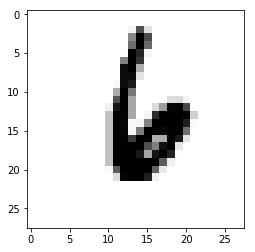

In [14]:
example_image = trainX[204, :, :, 0]
feed_dict = {tf_singleX : example_image[np.newaxis, :, :, np.newaxis]}
prediction = sess.run(predictions_single, feed_dict=feed_dict)

print('Predicted result:')
print(prediction.astype(int))
plt.imshow(example_image, cmap="Greys")